In [1]:
import os

import pandas as pd

from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets

from torch.utils.data import Dataset, DataLoader

from PIL import Image

In [2]:
class HAM10000Dataset(Dataset):

    def __init__(self, csv_file, img_dirs, transform=None):

        self.data = pd.read_csv(csv_file)

        self.img_dirs = img_dirs

        self.transform = transform

        self.label_map = {label: idx for idx, label in enumerate(self.data['dx'].unique())}



    def __len__(self):

        return len(self.data)



    def __getitem__(self, idx):

        img_name = self.data.iloc[idx]['image_id'] + '.jpg'

        img_path = None

        for dir in self.img_dirs:

            if os.path.exists(os.path.join(dir, img_name)):

                img_path = os.path.join(dir, img_name)

                break

        if img_path is None:

            raise FileNotFoundError(f"Image {img_name} not found in any of the specified directories.")

        

        image = Image.open(img_path).convert('RGB')

        label = self.label_map[self.data.iloc[idx]['dx']]

        

        if self.transform:

            image = self.transform(image)

        

        return image, label

In [3]:
# Setting the Metadata Path

metadata_path = '../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'



# Loading the Metadata

metadata = pd.read_csv(metadata_path)



# Checking the Number of Unique Images

print(f'Total number of images: {len(metadata)}')

Total number of images: 10015


In [4]:
# Splitting the metadata into training and testing sets

train_metadata, test_metadata = train_test_split(metadata, test_size=0.99, random_state=42)



# Saving the split metadata to CSV files

train_metadata.to_csv('train_metadata.csv', index=False)

test_metadata.to_csv('test_metadata.csv', index=False)

In [5]:
# Defining Image Directories

img_dirs = [

    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_1',

    '../input/skin-cancer-mnist-ham10000/HAM10000_images_part_2'

]



# Purpose of Image Directories

# These directories are likely part of the dataset's structure, where the images have been split into multiple parts for organizational purposes.

# By listing these directories, the code can later iterate through them to locate and load the images as needed.



# This setup is crucial for managing and accessing the image files efficiently.

# By specifying the directories in a list, the code can easily handle the images regardless of their distribution across multiple folders.

# This approach simplifies the process of loading and preprocessing the images for further analysis or model training.

In [6]:
transform = transforms.Compose([

    transforms.Resize((64, 64)),  # Resize images to 64x64

    transforms.ToTensor(),        # Convert to PyTorch tensor

    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize

])

In [7]:
# Creating Datasets

train_dataset = HAM10000Dataset(csv_file='train_metadata.csv', img_dirs=img_dirs, transform=transform)

test_dataset = HAM10000Dataset(csv_file='test_metadata.csv', img_dirs=img_dirs, transform=transform)



# Creating DataLoaders

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)



# Printing Dataset Sizes

print(f'Training dataset size: {len(train_dataset)}')

print(f'Testing dataset size: {len(test_dataset)}')

Training dataset size: 100
Testing dataset size: 9915


Image batch shape: torch.Size([4, 3, 64, 64])
Label batch shape: torch.Size([4])


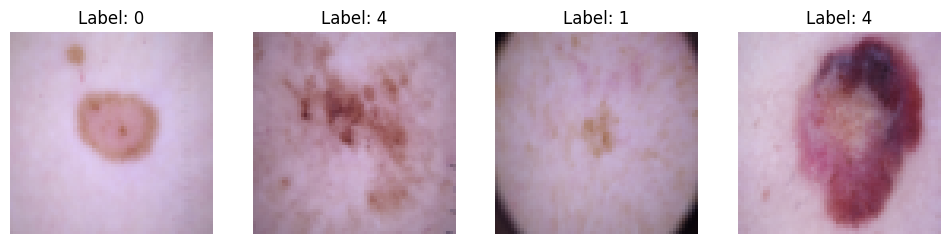

In [8]:
# Importing Matplotlib

import matplotlib.pyplot as plt



# Loading a Batch of Images

images, labels = next(iter(train_loader))



# Printing the shapes of the image and label batches

print(f'Image batch shape: {images.shape}')

print(f'Label batch shape: {labels.shape}')



# Creating a Figure for Display

fig, axes = plt.subplots(1, 4, figsize=(12, 4))



# Displaying the First 4 Images

for i in range(4):

    axes[i].imshow(images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5)

    axes[i].set_title(f"Label: {labels[i].item()}")

    axes[i].axis("off")



# Showing the Figure

plt.show()

In [9]:
import torch



import torch.nn as nn



# Self-Attention Class

class SelfAttention(nn.Module):

    def __init__(self, in_dim):

        super(SelfAttention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)

        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)

        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))



    def forward(self, x):

        batch_size, C, width, height = x.size()

        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)

        proj_key = self.key_conv(x).view(batch_size, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)

        attention = torch.softmax(energy, dim=-1)

        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))

        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x

        return out



# Residual Block Class

class ResidualBlock(nn.Module):

    def __init__(self, in_channels):

        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(

            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(in_channels),

            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(in_channels)

        )



    def forward(self, x):

        return x + self.block(x)



# Generator Class

class Generator(nn.Module):

    def __init__(self, latent_dim, img_channels, img_size):

        super(Generator, self).__init__()

        self.init_size = img_size // 4

        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))



        self.conv_blocks = nn.Sequential(

            nn.BatchNorm2d(128),

            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(128, 0.8),

            nn.ReLU(inplace=True),

            nn.Upsample(scale_factor=2),

            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(64, 0.8),

            nn.ReLU(inplace=True),

            nn.Conv2d(64, img_channels, kernel_size=3, stride=1, padding=1),

            nn.Tanh()

        )



        self.res_block = ResidualBlock(128)

        self.attention = SelfAttention(128)



    def forward(self, z):

        out = self.l1(z)

        out = out.view(out.shape[0], 128, self.init_size, self.init_size)

        out = self.res_block(out)

        out = self.attention(out)

        img = self.conv_blocks(out)

        return img



# Instantiating and Testing the Generator

latent_dim = 100

img_channels = 3

img_size = 64



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(latent_dim, img_channels, img_size).to(device)



# Generate a batch of images

z = torch.randn(4, latent_dim).to(device)

generated_images = generator(z)



# Print the shape of the generated images

print(f'Generated images shape: {generated_images.shape}')

Generated images shape: torch.Size([4, 3, 64, 64])


In [10]:
import torch.nn as nn



# Self-Attention Class

class SelfAttention(nn.Module):

    def __init__(self, in_dim):

        super(SelfAttention, self).__init__()

        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)

        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)

        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)

        self.gamma = nn.Parameter(torch.zeros(1))



    def forward(self, x):

        batch_size, C, width, height = x.size()

        proj_query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)

        proj_key = self.key_conv(x).view(batch_size, -1, width * height)

        energy = torch.bmm(proj_query, proj_key)

        attention = torch.softmax(energy, dim=-1)

        proj_value = self.value_conv(x).view(batch_size, -1, width * height)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))

        out = out.view(batch_size, C, width, height)

        out = self.gamma * out + x

        return out



# Residual Block Class

class ResidualBlock(nn.Module):

    def __init__(self, in_channels):

        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(

            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(in_channels),

            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),

            nn.BatchNorm2d(in_channels)

        )



    def forward(self, x):

        return x + self.block(x)



# Discriminator Class

class Discriminator(nn.Module):

    def __init__(self, img_channels, img_size):

        super(Discriminator, self).__init__()

        self.init_size = img_size // 4

        self.l1 = nn.Sequential(nn.Linear(img_channels * img_size ** 2, 128 * self.init_size ** 2))



        self.conv_blocks = nn.Sequential(

            nn.BatchNorm2d(128),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),

            nn.BatchNorm2d(128, 0.8),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1),

            nn.BatchNorm2d(64, 0.8),

            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),

            nn.Sigmoid()

        )



        self.res_block = ResidualBlock(128)

        self.attention = SelfAttention(128)



    def forward(self, img):

        out = self.l1(img.view(img.size(0), -1))

        out = out.view(out.shape[0], 128, self.init_size, self.init_size)

        out = self.res_block(out)

        out = self.attention(out)

        validity = self.conv_blocks(out)

        return validity.view(validity.size(0), -1)



# Instantiating and Testing the Discriminator

img_channels = 3

img_size = 64



discriminator = Discriminator(img_channels, img_size).to(device)



# Generate a batch of random fake images

fake_images = torch.randn(4, img_channels, img_size, img_size).to(device)

output = discriminator(fake_images)



# Print the shape of the discriminator's output

print(f'Discriminator output shape: {output.shape}')

Discriminator output shape: torch.Size([4, 16])


In [11]:
import warnings



# Ignore all warning messages

warnings.filterwarnings("ignore")



# Explanation:

# The warnings module is imported to handle warning messages in Python.

# The filterwarnings("ignore") function call sets a filter to ignore all warnings.

# This ensures that the output remains clean and free of warning messages.

# Use this with caution, as ignoring warnings might cause you to miss important information about potential issues in the code.

In [12]:
from tqdm import tqdm



import torch.optim as optim



def train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=1, lr=0.0002, beta1=0.5, beta2=0.999):

    # Move models to the specified device

    generator.to(device)

    discriminator.to(device)



    # Loss function

    criterion = nn.BCEWithLogitsLoss()



    # Optimizers

    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))



    # Mixed precision training

    scaler = torch.cuda.amp.GradScaler()



    for epoch in range(epochs):

        generator.train()

        discriminator.train()

        epoch_loss_G = 0.0

        epoch_loss_D = 0.0



        for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):

            batch_size = real_images.size(0)

            real_images = real_images.to(device)



            # Labels for real and fake images

            valid = torch.ones(batch_size, 1).to(device)

            fake = torch.zeros(batch_size, 1).to(device)



            # -----------------

            #  Train Generator

            # -----------------

            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim).to(device)



            with torch.cuda.amp.autocast():

                generated_images = generator(z)

                g_loss = criterion(discriminator(generated_images), valid)



            scaler.scale(g_loss).backward()

            scaler.step(optimizer_G)

            scaler.update()



            epoch_loss_G += g_loss.item()



            # ---------------------

            #  Train Discriminator

            # ---------------------

            optimizer_D.zero_grad()



            with torch.cuda.amp.autocast():

                real_loss = criterion(discriminator(real_images), valid)

                fake_loss = criterion(discriminator(generated_images.detach()), fake)

                d_loss = (real_loss + fake_loss) / 2



            scaler.scale(d_loss).backward()

            scaler.step(optimizer_D)

            scaler.update()



            epoch_loss_D += d_loss.item()



            # Clear CUDA cache

            torch.cuda.empty_cache()



        print(f"Epoch [{epoch+1}/{epochs}] | Generator Loss: {epoch_loss_G/len(train_loader):.4f} | Discriminator Loss: {epoch_loss_D/len(train_loader):.4f}")



# Example function call

# train_gan(generator, discriminator, train_loader, latent_dim, device, epochs=10)

In [13]:
import torch

from torchvision import models

import warnings



import torch.nn as nn

import torch.optim as optim



# Ignore all warning messages

warnings.filterwarnings("ignore")



# EfficientNetV2 Classifier

class EfficientNetV2Classifier(nn.Module):

    def __init__(self, num_classes=7):

        super(EfficientNetV2Classifier, self).__init__()

        self.model = models.efficientnet_v2_s(pretrained=True)

        self.model.classifier = nn.Sequential(

            nn.Dropout(p=0.2, inplace=True),

            nn.Linear(self.model.classifier[1].in_features, num_classes)

        )



    def forward(self, x):

        return self.model(x)



# Model Initialization

model_EfficientNetV2 = EfficientNetV2Classifier(num_classes=7)



# Loss and Optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_EfficientNetV2.parameters(), lr=0.001)



# Training Loop

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):

    model.to(device)

    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0

        total_correct = 0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            total_correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = total_correct.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        validate_model(model, test_loader, criterion, device)



# Validation Loop

def validate_model(model, test_loader, criterion, device='cuda'):

    model.eval()

    total_correct = 0

    total_loss = 0.0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            total_correct += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(test_loader.dataset)

    avg_acc = total_correct.double() / len(test_loader.dataset)

    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')



# Example function call

# train_model(model_EfficientNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 216MB/s]


In [14]:
import torch

from torchvision import models



import torch.nn as nn

import torch.optim as optim



# ShuffleNetV2 Classifier

class ShuffleNetV2Classifier(nn.Module):

    def __init__(self, num_classes=7):

        super(ShuffleNetV2Classifier, self).__init__()

        self.model = models.shufflenet_v2_x1_0(pretrained=True)

        self.model.fc = nn.Sequential(

            nn.Dropout(p=0.2, inplace=True),

            nn.Linear(self.model.fc.in_features, num_classes)

        )



    def forward(self, x):

        return self.model(x)



# Model Initialization

model_ShuffleNetV2 = ShuffleNetV2Classifier(num_classes=7)



# Loss and Optimizer

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model_ShuffleNetV2.parameters(), lr=0.001)



# Training Loop

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device='cuda'):

    model.to(device)

    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0

        total_correct = 0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            total_correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = total_correct.double() / len(train_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}')

        validate_model(model, test_loader, criterion, device)



# Validation Loop

def validate_model(model, test_loader, criterion, device='cuda'):

    model.eval()

    total_correct = 0

    total_loss = 0.0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            total_correct += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(test_loader.dataset)

    avg_acc = total_correct.double() / len(test_loader.dataset)

    print(f'Validation Loss: {avg_loss:.4f} | Validation Accuracy: {avg_acc:.4f}')



# Example function call

# train_model(model_ShuffleNetV2, train_loader, test_loader, criterion, optimizer, num_epochs=10)

Downloading: "https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth" to /root/.cache/torch/hub/checkpoints/shufflenetv2_x1-5666bf0f80.pth
100%|██████████| 8.79M/8.79M [00:00<00:00, 50.7MB/s]


In [15]:
def create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels, noise_dim=128):

    # Set the models to evaluation mode

    generator.eval()

    model_EfficientNetV2.eval()

    model_ShuffleNetV2.eval()



    # Generate random noise

    noise = torch.randn(len(labels), noise_dim).to(device)



    # Generate images using the generator model

    with torch.no_grad():

        created_imgs = generator(noise, labels)



    # Classify the generated images using both classifier models

    with torch.no_grad():

        EfficientNetV2Classifier_labels = model_EfficientNetV2(created_imgs)

        ShuffleNetV2Classifier_labels = model_ShuffleNetV2(created_imgs)



    # Check if both classifiers correctly identify the generated images

    if torch.equal(EfficientNetV2Classifier_labels.argmax(dim=1), labels) and torch.equal(ShuffleNetV2Classifier_labels.argmax(dim=1), labels):

        return created_imgs

    else:

        return None



# Example usage

# labels = torch.tensor([0, 1, 2, 3, 4, 5, 6]).to(device)  # Example labels

# support_set = create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels)

# if support_set is not None:

#     print("Support set created successfully.")

# else:

#     print("Failed to create a valid support set.")

In [16]:
import torch



import torch.nn as nn



class CNNEncoder(nn.Module):

    def __init__(self, in_channels=3, base_features=64):

        super(CNNEncoder, self).__init__()

        

        # Encoder Block 1

        self.block1 = nn.Sequential(

            nn.Conv2d(in_channels, base_features, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features),

            nn.ReLU(inplace=True),

            nn.Conv2d(base_features, base_features, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features),

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 64x64 to 32x32

        )

        

        # Encoder Block 2

        self.block2 = nn.Sequential(

            nn.Conv2d(base_features, base_features * 2, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 2),

            nn.ReLU(inplace=True),

            nn.Conv2d(base_features * 2, base_features * 2, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 2),

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 32x32 to 16x16

        )

        

        # Encoder Block 3

        self.block3 = nn.Sequential(

            nn.Conv2d(base_features * 2, base_features * 4, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 4),

            nn.ReLU(inplace=True),

            nn.Conv2d(base_features * 4, base_features * 4, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 4),

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 16x16 to 8x8

        )

        

        # Encoder Block 4

        self.block4 = nn.Sequential(

            nn.Conv2d(base_features * 4, base_features * 8, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 8),

            nn.ReLU(inplace=True),

            nn.Conv2d(base_features * 8, base_features * 8, kernel_size=3, padding=1),

            nn.BatchNorm2d(base_features * 8),

            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions from 8x8 to 4x4

        )



    def forward(self, x):

        x = self.block1(x)

        x = self.block2(x)

        x = self.block3(x)

        x = self.block4(x)

        return x



# Example usage

# encoder = CNNEncoder()

# input_tensor = torch.randn(1, 3, 64, 64)  # Batch size of 1, 3 color channels, 64x64 image

# output = encoder(input_tensor)

# print(output.shape)  # Should print torch.Size([1, 512, 4, 4])

In [17]:
import torch



import torch.nn as nn



class AttentionModule(nn.Module):

    def __init__(self, feature_dim, num_heads=4):

        super(AttentionModule, self).__init__()

        self.num_heads = num_heads

        self.head_dim = feature_dim // num_heads



        # Linear transformations for multi-head attention

        self.query_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)

        self.key_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)

        self.value_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)



        # Multi-head attention mechanism

        self.attn_heads = nn.ModuleList([

            nn.Sequential(

                nn.Conv2d(self.head_dim, self.head_dim, kernel_size=1),

                nn.Softmax(dim=-1)

            ) for _ in range(num_heads)

        ])



        # Channel attention

        self.channel_attention = nn.Sequential(

            nn.AdaptiveAvgPool2d(1),

            nn.Conv2d(feature_dim, feature_dim // 16, kernel_size=1),

            nn.ReLU(inplace=True),

            nn.Conv2d(feature_dim // 16, feature_dim, kernel_size=1),

            nn.Sigmoid()

        )



        # Spatial attention

        self.spatial_attention = nn.Sequential(

            nn.Conv2d(feature_dim, 1, kernel_size=7, padding=3),

            nn.Sigmoid()

        )



        # Final convolutional layer

        self.output_conv = nn.Conv2d(feature_dim, feature_dim, kernel_size=1)



    def forward(self, x):

        batch_size, C, H, W = x.size()



        # Compute query, key, and value maps

        query = self.query_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)

        key = self.key_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)

        value = self.value_conv(x).view(batch_size, self.num_heads, self.head_dim, -1)



        # Multi-head attention

        attn_outputs = []

        for i in range(self.num_heads):

            attn_weights = torch.bmm(query[:, i], key[:, i].permute(0, 2, 1))

            attn_weights = self.attn_heads[i](attn_weights.view(batch_size, self.head_dim, H, W)).view(batch_size, -1, H * W)

            attn_output = torch.bmm(attn_weights, value[:, i])

            attn_outputs.append(attn_output)



        # Concatenate attention outputs

        attn_output = torch.cat(attn_outputs, dim=1).view(batch_size, C, H, W)



        # Apply channel attention

        channel_attn = self.channel_attention(attn_output)

        attn_output = attn_output * channel_attn



        # Apply spatial attention

        spatial_attn = self.spatial_attention(attn_output)

        attn_output = attn_output * spatial_attn



        # Final convolutional layer

        output = self.output_conv(attn_output)

        return output



# Example usage

# feature_dim = 64

# num_heads = 4

# attention_module = AttentionModule(feature_dim, num_heads)

# input_tensor = torch.randn(1, feature_dim, 32, 32)  # Batch size of 1, feature_dim channels, 32x32 image

# output = attention_module(input_tensor)

# print(output.shape)  # Should print torch.Size([1, feature_dim, 32, 32])

In [18]:
import torch



import torch.nn as nn



class MTUNet2(nn.Module):

    def __init__(self, in_channels=3, base_features=64, num_classes=5, feature_dim=512, num_heads=4):

        super(MTUNet2, self).__init__()

        self.encoder = CNNEncoder(in_channels, base_features)

        self.attn_module = AttentionModule(feature_dim, num_heads)

        self.classifier = nn.Sequential(

            nn.Flatten(),

            nn.Linear(feature_dim * 2 * 4 * 4, 1024),

            nn.ReLU(inplace=True),

            nn.Linear(1024, num_classes)

        )



    def forward(self, query, support):

        # Step 1: Extract features from the query image

        query_features = self.encoder(query)  # [B, 1024, 8, 8]



        # Step 2: Extract and aggregate features from the support set

        support_features = torch.stack([self.encoder(s) for s in support], dim=0)  # [N, B, 1024, 8, 8]

        support_features = support_features.mean(dim=0)  # [B, 1024, 8, 8]



        # Step 3: Apply the attention module to both query and support features

        query_features = self.attn_module(query_features)

        support_features = self.attn_module(support_features)



        # Step 4: Combine the query and support features

        combined_features = torch.cat([query_features, support_features], dim=1)  # [B, 2048, 8, 8]



        # Step 5: Pass the combined features through the classification decoder

        output = self.classifier(combined_features)

        return output



# Example usage

# model = MTUNet2()

# query = torch.randn(1, 3, 64, 64)  # Batch size of 1, 3 color channels, 64x64 image

# support = [torch.randn(1, 3, 64, 64) for _ in range(5)]  # 5 support images

# output = model(query, support)

# print(output.shape)  # Should print torch.Size([1, num_classes])

In [19]:
# Initialization

model = MTUNet2(in_channels=3, base_features=64, num_classes=5, feature_dim=512, num_heads=4).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)



# Training Function

def train(model, train_loader, criterion, optimizer, epoch):

    model.train()

    running_loss = 0.0

    total_correct = 0

    for inputs, labels in train_loader:

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        

        # Create support set

        support_set = create_support_set(generator, model_EfficientNetV2, model_ShuffleNetV2, labels)

        if support_set is None:

            continue

        

        # Forward pass

        outputs = model(inputs, support_set)

        loss = criterion(outputs, labels)

        

        # Backward pass and optimization

        loss.backward()

        optimizer.step()

        

        running_loss += loss.item() * inputs.size(0)

        _, preds = torch.max(outputs, 1)

        total_correct += torch.sum(preds == labels.data)

    

    epoch_loss = running_loss / len(train_loader.dataset)

    epoch_acc = total_correct.double() / len(train_loader.dataset)

    return epoch_loss, epoch_acc



# Evaluation Function

def evaluate(model, test_loader, criterion):

    model.eval()

    test_loss = 0.0

    total_correct = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            

            # Forward pass

            outputs = model(inputs, support_set)

            loss = criterion(outputs, labels)

            

            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            total_correct += torch.sum(preds == labels.data)

    

    avg_loss = test_loss / len(test_loader.dataset)

    avg_acc = total_correct.double() / len(test_loader.dataset)

    return avg_loss, avg_acc



# Main Training Loop

num_epochs = 10

for epoch in range(num_epochs):

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, epoch)

    print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}')

    

    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f'Epoch {epoch+1}/{num_epochs} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}')

TypeError: Generator.forward() takes 2 positional arguments but 3 were given